## Output of this notebook:
    Q.6: posterior skills updated with match result obervations
    Q.7: prediction accuracy within the one-step-ahead prediction procedure
    Q.11: convergence for hyperparameter tuning (variance for the match result variable t) if needed

In [1]:
import numpy as np
from scipy import stats
from scipy import optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

#### (TUNE_VAR == True) enables tuning of $\sigma_t^2$

In [2]:
S_E = (25/6)**2

user_choice = input("Do you want to tune variance for a match result (y/n)?\n")
TUNE_VAR = True if (user_choice.lower() == "y") else False

Do you want to tune variance for a match result (y/n)?
y


In [4]:
# Tune variance for t to replace S_E if needed
def tune_match_variance(t, m1, m2, v1, v2, s0):
    '''s_e = argmax(Marginal Likelihood for data given in array t)'''
    # marginal loglikelihood for optimization
    def cost_func(sigma):
        s = sigma + v1 + v2 # sigma = \sigma_t^2
        return np.sum( np.log(s) + (t - (m1 - m2))**2 / s )
    
    # derivative of marginal loglikelihood for optimization
    def cost_func_grad(sigma):
        s = sigma + v1 + v2
        return np.sum( s**(-1) - (t - (m1 - m2))**2 * s**(-2) )

    opt_res = opt.minimize(cost_func, x0=s0, method='cg', jac=cost_func_grad)
    s_e = float(opt_res.x)
    return s_e

In [5]:
class Skill:
    def __init__(self, mu=25, var=(25/3)**2):
        self.mu = mu
        self.var = var


class Team:
    def __init__(self, name, skill):
        self.name = name
        self.skill = skill

    def predict(self, another, s_e=S_E):
        lose_rate = stats.norm.cdf(x=0,
                                   loc=self.skill.mu - another.skill.mu,
                                   scale=(self.skill.var + another.skill.var + s_e) ** 0.5)
        win_rate = 1 - lose_rate
        return win_rate

    def update(self, another, result, num_samples=3000, drops=1000):
        posterior = []
        post_weights = []
        s1 = self.skill.mu
        s1_w = self.skill.var

        for _ in range(num_samples):
            s2 = stats.norm.rvs(another.skill.mu, another.skill.var ** 0.5)
            s2_w = self._importance(s1, s2, result)

            posterior.append((s1, s2))
            post_weights.append((s1_w, s2_w))

            s1 = stats.norm.rvs(self.skill.mu, self.skill.var ** 0.5)
            s1_w = self._importance(s1, s2, result)

        posterior = np.array(posterior)
        post_weights = np.array(post_weights)

        self.skill.mu, self.skill.var = self._approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
        another.skill.mu, another.skill.var = self._approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])

    @staticmethod
    def _approx_gaussian(samples, importances):
        mu = np.average(samples, weights=importances)
        var = np.average((samples - mu) ** 2, weights=importances)
        return mu, var

    @staticmethod
    def _importance(s1, s2, y=1):
        pr = 1 - stats.norm(s1 - s2, S_E ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, S_E ** 0.5).cdf(0)
        return pr

In [17]:
# READ DATA
df = pd.read_csv('SerieA.csv', sep=',', header=0)
data = df.to_numpy()

teams = {name: Team(name, Skill()) for name in np.unique(data[:, 2:4])}

num_predictions = 0
correct_predictions = 0

# for tuning match variance
if TUNE_VAR:
    t_arr = np.empty((0))
    m_arr = np.empty((0, 2))
    v_arr = np.empty((0, 2))
    s_e = S_E

## Predict match result and update the posterior

In [18]:
for match in data:

    team1 = teams[match[2]]
    team2 = teams[match[3]]

    # skip draws
    if match[4] == match[5]:
        continue

    # for tuning match variance
    if TUNE_VAR:
        t_arr = np.append(t_arr, team2.skill.mu - team2.skill.var)
        m_arr = np.append(m_arr, [[team1.skill.mu, team2.skill.mu]], axis=0)
        v_arr = np.append(v_arr, [[team1.skill.var, team2.skill.var]], axis=0)
        s_e = tune_match_variance(t_arr, m_arr[:, 0], m_arr[:, 1], v_arr[:, 0], v_arr[:, 1], s0=s_e) # compute optimal variance given observed results
        s_e_conv = []
    else:
        s_e = S_E

    num_predictions += 1
    result = 1 if match[4] > match[5] else -1
    print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    print(f"Team 1 rate: {round(team1.predict(team2, s_e=s_e), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2, s_e=s_e) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result)
    print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
          f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    
    if TUNE_VAR:
        s_e_conv.append(s_e)

    print("=======================================================")

Before match: Chievo: 25-69.44 vs Juventus: 25-69.44
Team 1 rate: 0.5 ==================== Result: -1
After match: Chievo: 20.18-52.3 vs Juventus: 29.4-47.95
Before match: Lazio: 25-69.44 vs Napoli: 25-69.44
Team 1 rate: 0.5 ==================== Result: -1
After match: Lazio: 20.76-48.52 vs Napoli: 29.3-45.47
Before match: Torino: 25-69.44 vs Roma: 25-69.44
Team 1 rate: 0.5 ==================== Result: -1
After match: Torino: 20.49-51.11 vs Roma: 29.22-49.74
Before match: Sassuolo: 25-69.44 vs Inter: 25-69.44
Team 1 rate: 0.5 ==================== Result: 1
After match: Sassuolo: 29.42-50.64 vs Inter: 20.73-51.08
Before match: Empoli: 25-69.44 vs Cagliari: 25-69.44
Team 1 rate: 0.5 ==================== Result: 1
After match: Empoli: 29.35-45.48 vs Cagliari: 20.52-50.0
Before match: Bologna: 25-69.44 vs Spal: 25-69.44
Team 1 rate: 0.5 ==================== Result: -1
After match: Bologna: 20.82-47.35 vs Spal: 29.63-49.65
Before match: Atalanta: 25-69.44 vs Frosinone: 25-69.44
Team 1 rate:

KeyboardInterrupt: 

### Output posterior distribution parameters and  prediction accuracy

In [ ]:
with open("result.txt", "w") as f:
    f.write("name, mu, var\n")
    for _, v in teams.items():
        f.write(f"{v.name}, {round(v.skill.mu, 4)}, {round(v.skill.var, 4)}\n")
    f.write(f"==========================\nPrediction accuracy: {correct_predictions/num_predictions}")

### Plot hyperparameter convergence during its tuning if TUNE_VAR == True

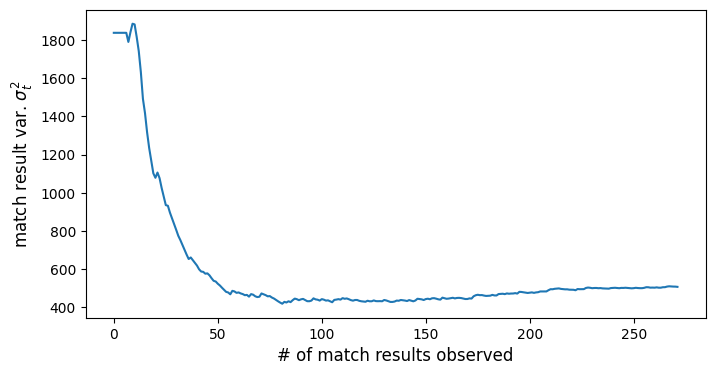

In [22]:
if TUNE_VAR:
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(s_e_conv)), s_e_conv)
    plt.xlabel("# of match results observed", fontsize=12)
    plt.ylabel("match result var. $\sigma_t^2$", rotation=90, fontsize=12)

## Plot the final posterior results for the skill of each team

In [13]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [14]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]


def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

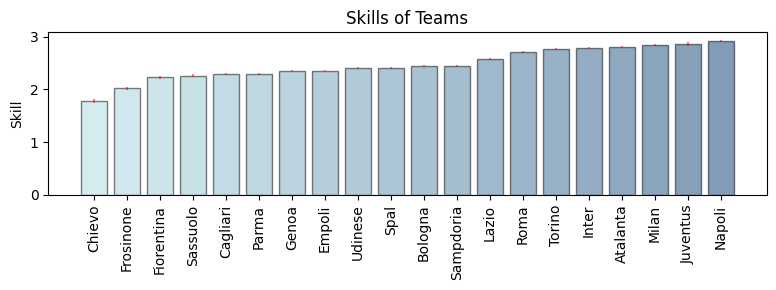

In [15]:
data = pd.read_csv('result.txt', sep=',', header=0).to_numpy()[:-2, :]

data = data[data[:, 1].argsort()]

figure(figsize=(8, 3))

color1 = "#abdbe3"
color2 = "#063970"


pyplot.bar(data[:, 0], data[:, 1], yerr=data[:, 2], alpha=0.5, align='center',
           color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
           error_kw=dict(ecolor='red', alpha=0.5))
pyplot.xticks(rotation=90)
pyplot.ylabel("Skill")
pyplot.title("Skills of Teams")

# Save the figure and show
pyplot.tight_layout()
pyplot.savefig('skill_ranking.pdf', dpi=500)